# Experiment
 Draw the fiture for the first experiment by matplot. 
1. show the data graphs. 
2. compare the running time. 


In [7]:
import sys
import re
import os.path
import time
import datetime
import csv
import numpy as np
import scipy.stats
import scipy as sp
import re
import matplotlib.pyplot as plt
from tabulate import tabulate

#path = "/home/guob15/git-code/core-maintenance/experiment/results/" 
#path = "/home/guo/Documents/git-code/core-maintenance/experiment/results/"
ispdf = False
path = "../results/"
files = [
    #"results-9-16-2021-hp.csv"
    #"results-9-15-2021-hp-core2.csv"
    #"results-9-20-2021-hp.csv"
    "results-10-4-2021-T5-hp.csv" #T5 the average running time for repeated random graphs. 10 times test.
]

graph_name = [
    "livej",
    "patent", 
    "wikitalk",
    "roadNetCA",
    "dbpedia",
    "baidu",
    "pokec",
    "wiki_talk_en",
    "wiki-links",
    #"ssca2",
    # "com-friendster",
    # "twitter",
    # "twitter_mpi",
    "er-1m-8m",
    "ba-1m-8m",
    "rmat-1m-8m"
]

# for stability test or scalability test
selected_graph = {"wikitalk", "roadNetCA", "dbpedia", "ba-1m-8m"}

graph_title = [
    "livej",
    "patent",
    "wikitalk",
    "roadNet-CA",

    "dbpedia",
    "baidu", 
    "pokec",
    "wiki-talk-en",
    "wiki-links-en",
    #"ssca2",

    # "com-friendster",
    # "twitter",
    # "twitter-mpi",

    "ER",
    "BA",
    "RMAT",
]
all_graph_name = set() # load all graphs


algs = ["2", "3"] # Order-Based, our Simplified Order-Based, 
workers = [1] #[1, 2, 4, 6, 8, 10, 12, 14, 16, 32]
data = [] # load all data in csv files

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return round(m, 2), round(h, 2), round(h, 2)
def mean_min_max(data):
    mean_time = np.mean(data)
    min_time = np.min(data)
    max_time = np.max(data)
    return (mean_time, round(max_time-mean_time,2), round(mean_time-min_time,2))
def read_data():
    global data
    for p in files:
        p = path + p
        f = open(p,'rt')
        reader = csv.DictReader(f)
        for row in reader:
            #if float(row["mstime"]) < 0: continue 
            all_graph_name.add(row["model"])
            data.append(row)
        f.close()
def parse_data_time(model, worker, alg, isInsert, isInit=False):
    global data
    mstimes = []
    for row in data:
        if model != row["model"]: continue
        if str(worker) != row["workers"]: continue
        if alg != row["alg"]: continue
        if isInit: mstimes.append(float(row["init-mstime"])); continue
        if isInsert and "0" != row["insert-num"]: 
            mstimes.append(float(row["mstime"]))
        if (not isInsert) and "0" != row["remove-num"]:
            mstimes.append(float(row["mstime"]))
    if len(mstimes) != 0 : 
        return mean_confidence_interval(mstimes)
    else: assert("data not find!")
read_data()

## Graph information

In [10]:
def read_graph_core_data(name): #graph name
    x = []; y = []
    p = path + "graph-core/" + name +".bin.core"
    with open(p,'rt') as f:
        reader = csv.reader(f, delimiter=",")
        for row in reader: x.append(int(row[0])); y.append(int(row[1]))
    return x, y   
def draw_graph_info_table():
    global data
    lines = [["Graph", "|V|", "|E|","avg. deg", "max k"]]
    for model, title in zip(graph_name, graph_title):
        line=[title]
        n = 0; m = 0
        for row in data: 
            if model == row["model"]: n = int(row["N"]); m = int(row["M"]); break
        strn = '{:,}'.format(n); strm =  '{:,}'.format(m); strdeg =  '{:,.2f}'.format(m/n)
        line.append(strn); line.append(strm); line.append(strdeg)
        x, y = read_graph_core_data(model)
        strk = '{:,}'.format(x[-1]); line.append(strk)
        lines.append(line)
    print(tabulate(lines))
    print("")
    for line in lines:
        print(" & ".join(line) + " \\\\")
draw_graph_info_table()

-------------  ---------  -----------  --------  -----
Graph          |V|        |E|          avg. deg  max k
livej          4,847,571  68,993,773   14.23     372
patent         6,009,555  16,518,948   2.75      64
wikitalk       2,394,385  5,021,410    2.10      131
roadNet-CA     1,971,281  5,533,214    2.81      3
dbpedia        3,966,925  13,820,853   3.48      20
baidu          2,141,301  17,794,839   8.31      78
pokec          1,632,804  30,622,564   18.75     47
wiki-talk-en   2,987,536  24,981,163   8.36      210
wiki-links-en  5,710,993  130,160,392  22.79     821
ER             1,000,000  8,000,000    8.00      11
BA             1,000,000  7,999,964    8.00      8
RMAT           999,760    7,810,950    7.81      237
-------------  ---------  -----------  --------  -----

Graph & |V| & |E| & avg. deg & max k \\
livej & 4,847,571 & 68,993,773 & 14.23 & 372 \\
patent & 6,009,555 & 16,518,948 & 2.75 & 64 \\
wikitalk & 2,394,385 & 5,021,410 & 2.10 & 131 \\
roadNet-CA & 1,971,281 

## Real Running Time Test
Compare the running time for the repeated edges 

In [11]:
# draw a speedup table for insertion and removal
def draw_speedup_table():
    global graph_name, graph_title, algs
    lines = [['Graph',"Insertion",  "Batch-Insertion", "Removal","Init"]]
    for model, title in zip(graph_name, graph_title):
        line = [title]
        r2 = parse_data_time(model, 1, "2", True)[0]
        r3 = parse_data_time(model, 1, "3", True)[0] #ours insert
        speedup = r2/r3; line.append(str(round(speedup,2)))

        r2 = parse_data_time(model, 1, "2", True)[0]
        r3 = parse_data_time(model, 1, "13", True)[0] #ours batch-insert
        speedup = r2/r3; line.append(str(round(speedup,2)))

        r2 = parse_data_time(model, 1, "2", False)[0]
        r3 = parse_data_time(model, 1, "3", False)[0] #ours remove
        speedup = r2/r3; line.append(str(round(speedup,2)))
        
        r2 = parse_data_time(model, 1, "2", False, True)[0]
        r3 = parse_data_time(model, 1, "3", False, True)[0] #ours remove
        speedup = r2/r3; line.append(str(round(speedup,2)))
        lines.append(line)
    print(tabulate(lines))
    print("")
    for line in lines:
        print(" & ".join(line) + " \\\\")
draw_speedup_table()

-------------  ---------  ---------------  -------  ----
Graph          Insertion  Batch-Insertion  Removal  Init
livej          2.04       1.66             1.87     1.02
patent         3.37       2.68             4.41     1.04
wikitalk       1.34       1.63             1.15     1.26
roadNet-CA     4.51       2.95             8.56     1.17
dbpedia        2.49       2.14             1.49     1.08
baidu          1.7        1.68             1.33     1.04
pokec          2.67       2.37             2.87     1.03
wiki-talk-en   1.36       1.45             1.04     1.2
wiki-links-en  1.31       1.16             1.09     1.02
ER             3.97       2.76             9.72     1.08
BA             7.69       5.26             7.42     1.15
RMAT           1.29       1.31             0.97     1.09
-------------  ---------  ---------------  -------  ----

Graph & Insertion & Batch-Insertion & Removal & Init \\
livej & 2.04 & 1.66 & 1.87 & 1.02 \\
patent & 3.37 & 2.68 & 4.41 & 1.04 \\
wikitalk & 1.3

<Figure size 1440x360 with 0 Axes>

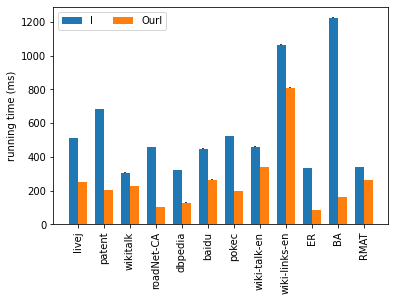

<Figure size 1440x360 with 0 Axes>

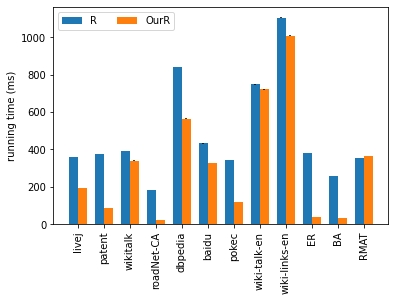

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# draw the bar chart to show the running time. 
def draw_running_time_bar(isInsert, filename, method):
    global graph_name, graph_title, algs
    # x is graph title, y is the running time
    N = len(graph_name); ind = np.arange(N);
    plt.figure(figsize=(20, 5))
    fig, ax = plt.subplots()
    
    ymean2=[]; yerr2=[]; ymean3=[]; yerr3=[]; ymean13=[]; yerr13=[]
    for model, title in zip(graph_name, graph_title):
        r2 = parse_data_time(model, 1, "2", isInsert); ymean2.append(r2[0]); yerr2.append(r2[1])
        r3 = parse_data_time(model, 1, "3", isInsert); ymean3.append(r3[0]); yerr3.append(r3[1])
        r13 = parse_data_time(model, 1, "13", isInsert); ymean13.append(r3[0]); yerr13.append(r3[1])
    width=0.35
    #width = 0.25
    ax.bar(ind, ymean2, width, bottom=0, yerr=yerr2, label= method, fill=True)
    #, hatch='///')
    ax.bar(ind+width, ymean3, width, bottom=0, yerr=yerr3, label='Our'+method, fill=True)
    #, fill=True, hatch='..')
    #if isInsert:
    #    ax.bar(ind+width*2, ymean3, width, bottom=0, yerr=yerr13, label='Our-B'+method)

    #ax.set_title('Scores by group and gender')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(graph_title)
    ax.set_ylabel("running time (ms)")
    
    #ax.set_yscale("log")
    ax.legend(ncol=2)
    ax.autoscale_view()
    plt.xticks(rotation=90)
    
    plt.savefig(filename, bbox_inches='tight')
    #plt.show()
draw_running_time_bar(True, "time-insert.pdf", "I")
draw_running_time_bar(False, "time-remove.pdf", "R")
        

## Stability Test
Compare the running time for random edges.
to see the fluctuation of running time. 

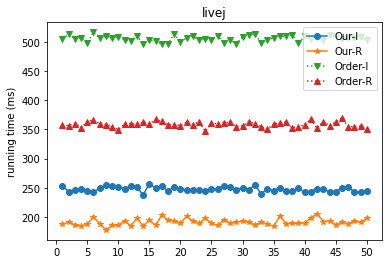

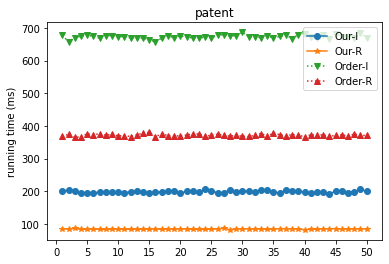

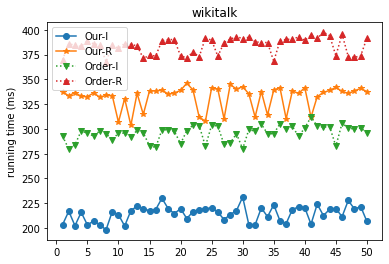

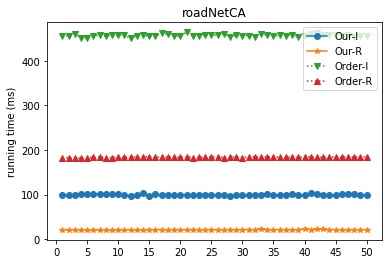

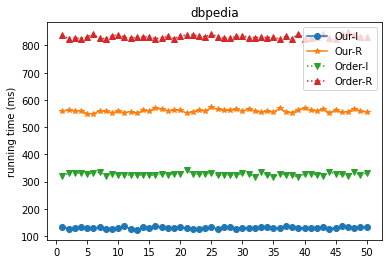

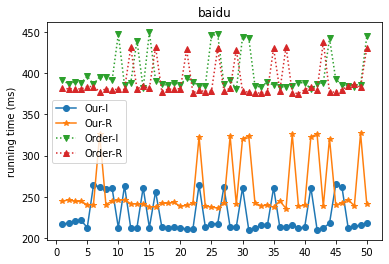

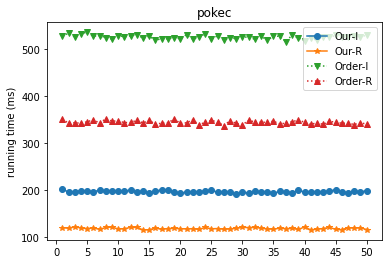

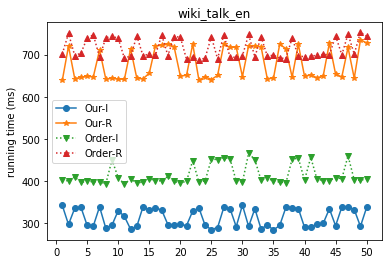

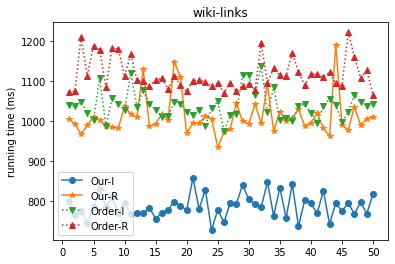

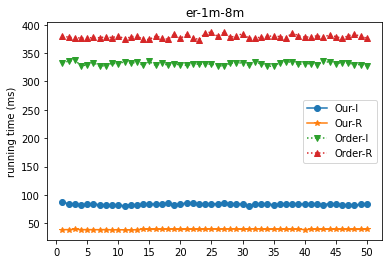

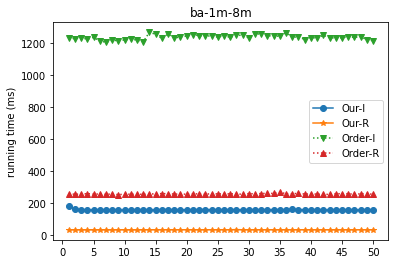

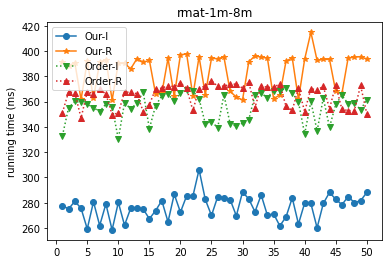

In [13]:
files = [
    "results-10-9-2021-T3-hp.csv" #T5 the average running time for repeated random graphs.
]
def read_all_data_time(model, worker, alg, isInsert, isInit=False):
    global data; mstimes = []; index = []; i = 1
    for row in data:
        if model != row["model"]: continue
        if str(worker) != row["workers"]: continue
        if alg != row["alg"]: continue
        if isInit: mstimes.append(float(row["init-mstime"])); continue
        if isInsert and "0" != row["insert-num"]: mstimes.append(float(row["mstime"])); index.append(i); i = i+1; continue
        if (not isInsert) and "0" != row["remove-num"]: mstimes.append(float(row["mstime"])); index.append(i); i = i+1; continue
    return index, mstimes
def draw_fluctuation():
    for name in graph_name:
        x, y = read_all_data_time(name, "1", "3", True)
        x2, y2 = read_all_data_time(name, "1", "3", False)
        x3, y3 = read_all_data_time(name, "1", "2", True)
        x4, y4 = read_all_data_time(name, "1", "2", False)
        plt.plot(x, y, label="Our-I", marker="o", ); #plt.yscale("log")
        plt.plot(x2, y2, label="Our-R", marker="*"); #plt.yscale("log")
        plt.plot(x3, y3, label="Order-I", marker="v", linestyle='dotted'); #plt.yscale("log")
        plt.plot(x4, y4, label="Order-R", marker="^", linestyle='dotted'); #plt.yscale("log")
        #plt.xlabel("repeat times")
        plt.ylabel("running time (ms)")
        plt.legend()
        plt.title(name)
        
        
        # make the x ticks integers, not floats
#         xint = []
#         locs, labels = plt.xticks()
#         for each in locs:
#             xint.append(int(each))
#         xint = xint[1:]
#         print(xint)
#         plt.xticks(xint)
        plt.xticks(list(range(0,51, 5)))
        
        
        #plt.savefig(name+".pdf")
        plt.show()
global data; data=[]; read_data(); draw_fluctuation()

### Stability Test All

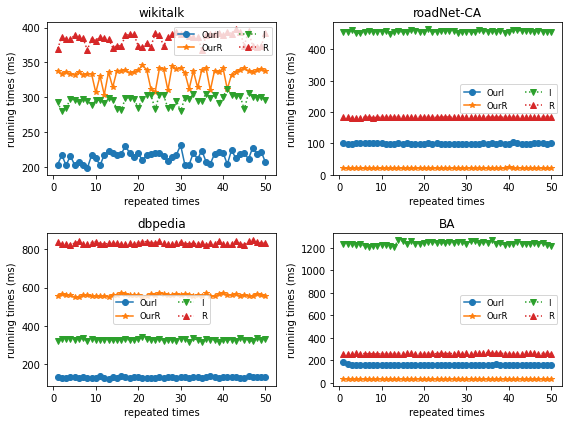

In [14]:
files = [
    "results-10-9-2021-T3-hp.csv" #T5 the average running time for repeated random graphs.
]
def read_all_data_time(model, worker, alg, isInsert, isInit=False):
    global data; mstimes = []; index = []; i = 1
    for row in data:
        if model != row["model"]: continue
        if str(worker) != row["workers"]: continue
        if alg != row["alg"]: continue
        if isInit: mstimes.append(float(row["init-mstime"])); continue
        if isInsert and "0" != row["insert-num"]: mstimes.append(float(row["mstime"])); index.append(i); i = i+1; continue
        if (not isInsert) and "0" != row["remove-num"]: mstimes.append(float(row["mstime"])); index.append(i); i = i+1; continue
    return index, mstimes
def draw_fluctuation(selected):
    global graph_name; global graph_title
    index = 1
    
    if selected: fig = plt.figure(figsize=(8, 6)) #fig = plt.figure(figsize=(17, 3))
    else: fig = plt.figure(figsize=(16, 9))
    
    for name, title in zip(graph_name, graph_title):
        if selected: 
            if name not in selected_graph: continue
       
        if selected: ax = fig.add_subplot(2,2, index)
        else: ax = fig.add_subplot(3, 4, index)
        
        index += 1
        ax.set_xlabel("repeated times")
        ax.set_ylabel("running times (ms)")
        
        x, y = read_all_data_time(name, "1", "3", True)
        x2, y2 = read_all_data_time(name, "1", "3", False)
        x3, y3 = read_all_data_time(name, "1", "2", True)
        x4, y4 = read_all_data_time(name, "1", "2", False)
        ax.plot(x, y, label="OurI", marker="o", ); #plt.yscale("log")
        ax.plot(x2, y2, label="OurR", marker="*"); #plt.yscale("log")
        ax.plot(x3, y3, label="I", marker="v", linestyle='dotted'); #plt.yscale("log")
        ax.plot(x4, y4, label="R", marker="^", linestyle='dotted'); #plt.yscale("log")
        ax.legend(fontsize="small", ncol=2)
        #ax.legend(ncol=2)
        ax.set_title(title)
        ax.set_xticks(list(range(0,51, 10)))  
    fig.align_labels()
    fig.tight_layout()
    if selected: plt.savefig("stability-.pdf") 
    else: plt.savefig("stability.pdf")
    plt.show()
global data; data=[]; read_data(); draw_fluctuation(True)

## Scability Test
Compare the running time by sameple a part of edges. 

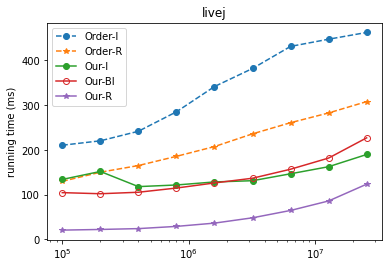

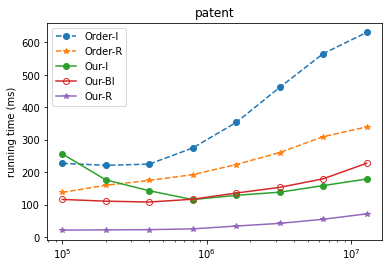

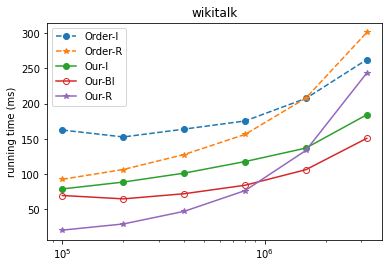

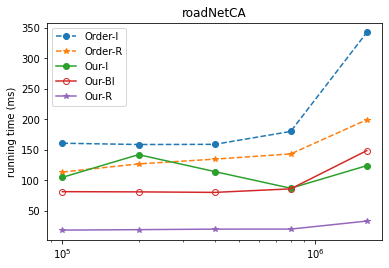

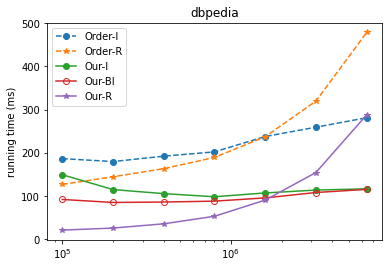

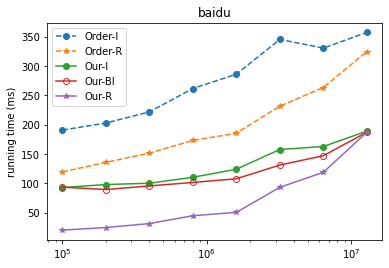

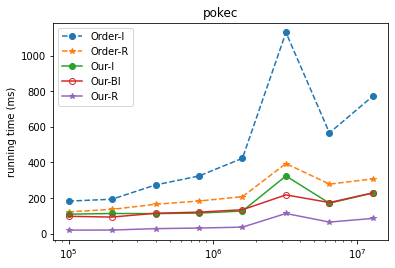

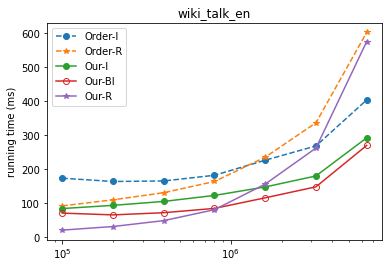

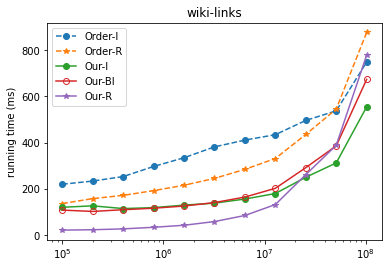

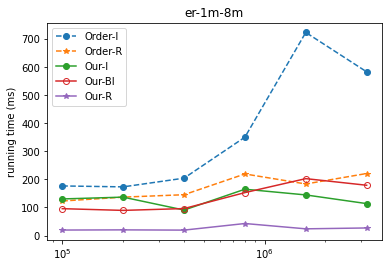

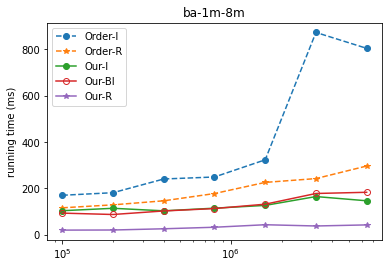

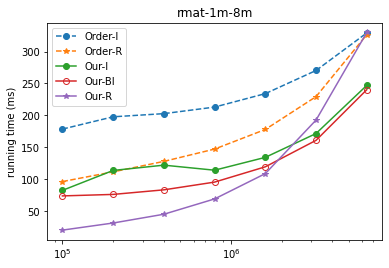

In [15]:
files = [
    "results-10-13-2021-T5-sample-hp.csv" #T5 the average running time for repeated random graphs.
]
edge_nums = [100000, 200000, 400000, 800000, 1600000, 3200000, 6400000, 12800000, 25600000, 51200000, 102400000]

def read_data_time_sample_edges(model, worker, alg, snum,  isInsert, isInit=False):
    global data; mstimes = [];
    for row in data:
        if model != row["model"]: continue
        if str(worker) != row["workers"]: continue
        if alg != row["alg"]: continue
        if str(snum) != row["snum"]: continue
        if isInit: mstimes.append(float(row["init-mstime"])); continue
        if isInsert and "0" != row["insert-num"]: mstimes.append(float(row["mstime"])); continue
        if (not isInsert) and "0" != row["remove-num"]: mstimes.append(float(row["mstime"])); continue
    if len(mstimes) == 0: return 0
    else: return mean_confidence_interval(mstimes)[0]

def draw_time_sample_edges():
    for name in graph_name:
        x = []; y1 =[]; y2=[]; y3=[]; y4=[]; y5=[]
        for num in edge_nums: 
            r1 = read_data_time_sample_edges(name, "1", "3", num, True)
            r2 = read_data_time_sample_edges(name, "1", "13", num, True)
            r3 = read_data_time_sample_edges(name, "1", "3", num, False)
            r4 = read_data_time_sample_edges(name, "1", "2", num, True)
            r5 = read_data_time_sample_edges(name, "1", "2", num, False)
            if r1 != 0: x.append(num); y1.append(r1); y2.append(r2); y3.append(r3); y4.append(r4); y5.append(r5)
            else: break
        
        plt.plot(x, y4, label="Order-I", marker="o", linestyle='dashed')
        plt.plot(x, y5, label="Order-R", marker="*", linestyle='dashed')
        
        plt.plot(x, y1, label="Our-I", marker="o"); #plt.yscale("log")
        plt.plot(x, y2, label="Our-BI", marker="o", fillstyle='none'); #plt.yscale("log")
        plt.plot(x, y3, label="Our-R", marker="*");

        #plt.xlabel("repeat times")
        plt.ylabel("running time (ms)")
        #plt.xticks(x); 
        plt.xscale("log")
        plt.legend()
        plt.title(name)
        
        #make the x ticks integers, not floats
#         xint = []
#         locs, labels = plt.xticks()
#         for each in locs:
#             xint.append(int(each))
#         xint = xint[1:]
#         print(xint)
#         plt.xticks(xint)
        
        
        #plt.savefig(name+".pdf")
        plt.show()
global data; data=[]; read_data(); draw_time_sample_edges()

### Scability Test All

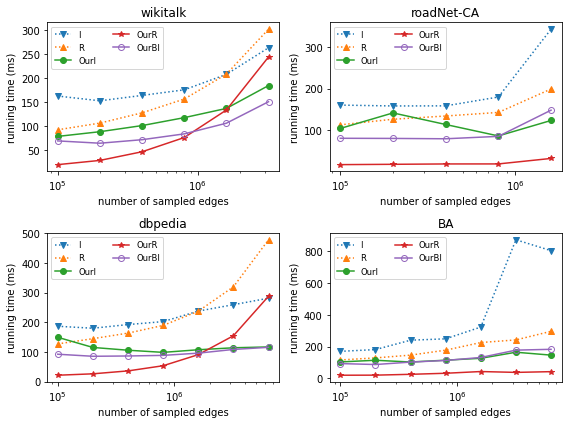

In [16]:
files = [
    "results-10-13-2021-T5-sample-hp.csv" #T5 the average running time for repeated random graphs.
]
edge_nums = [100000, 200000, 400000, 800000, 1600000, 3200000, 6400000, 12800000, 25600000, 51200000, 102400000]

def read_data_time_sample_edges(model, worker, alg, snum,  isInsert, isInit=False):
    global data; mstimes = [];
    for row in data:
        if model != row["model"]: continue
        if str(worker) != row["workers"]: continue
        if alg != row["alg"]: continue
        if str(snum) != row["snum"]: continue
        if isInit: mstimes.append(float(row["init-mstime"])); continue
        if isInsert and "0" != row["insert-num"]: mstimes.append(float(row["mstime"])); continue
        if (not isInsert) and "0" != row["remove-num"]: mstimes.append(float(row["mstime"])); continue
    if len(mstimes) == 0: return 0
    else: return mean_confidence_interval(mstimes)[0]

def draw_time_sample_edges(selected):
    global graph_name; global graph_title
    index = 1
    
        
    if selected: fig = plt.figure(figsize=(8, 6)) #fig = plt.figure(figsize=(17, 3))
    else: fig = plt.figure(figsize=(16, 9))
    
    for name, title in zip(graph_name, graph_title):
        if selected: 
            if name not in selected_graph: continue
            
        if selected: ax = fig.add_subplot(2,2, index)
        else: ax = fig.add_subplot(3, 4, index)
        
        index += 1
        ax.set_xlabel("number of sampled edges")
        ax.set_ylabel("running time (ms)")
        
        x = []; y1 =[]; y2=[]; y3=[]; y4=[]; y5=[]
        for num in edge_nums: 
            r1 = read_data_time_sample_edges(name, "1", "3", num, True)
            r2 = read_data_time_sample_edges(name, "1", "13", num, True)
            r3 = read_data_time_sample_edges(name, "1", "3", num, False)
            r4 = read_data_time_sample_edges(name, "1", "2", num, True)
            r5 = read_data_time_sample_edges(name, "1", "2", num, False)
            if r1 != 0: x.append(num); y1.append(r1); y2.append(r2); y3.append(r3); y4.append(r4); y5.append(r5)
            else: break
        
        ax.plot(x, y4, label="I", marker="v", linestyle='dotted')
        ax.plot(x, y5, label="R", marker="^", linestyle='dotted')
        ax.plot(x, y1, label="OurI", marker="o"); #plt.yscale("log")
        ax.plot(x, y3, label="OurR", marker="*");
        ax.plot(x, y2, label="OurBI", marker="o", fillstyle='none'); #plt.yscale("log")

        ax.set_xscale("log")
        ax.legend(fontsize="small", ncol=2)
        ax.set_title(title)
    fig.align_labels()
    fig.tight_layout()
    if selected: plt.savefig("scability-.pdf") 
    else: plt.savefig("scability.pdf")
    plt.show()
global data; data=[]; read_data(); draw_time_sample_edges(True)

### Scability Table
show more data besides the figure.

In [17]:
def int_string(strnum):
    if len(strnum) > 3: 
        str1 = strnum[:-3]; str2 = strnum[-3:]
        if int(str2[0]) > 5: str1 = str(int(str1) + 1)
        str1 =  '{:,}'.format(int(str1)) + "K"
        return str1
    else: return strnum
def int_string2(strnum):
    str1 = str(float(strnum)/1000000); return str1+"M"
def read_data_other_sample_edges(model, worker, alg, snum,  isInsert, isInit=False):
    global data;
    for row in data:
        if model != row["model"]: continue
        if str(worker) != row["workers"]: continue
        if alg != row["alg"]: continue
        if str(snum) != row["snum"]: continue
        if isInit: mstimes.append(float(row["init-mstime"])); continue
        if isInsert and "0" != row["insert-num"]:
            if alg == "3": return [int_string(row["V*"]), int_string(row["V+"]), int_string(row["tag"])]
            else: return [int_string(row["V*"]), int_string(row["V+"]), int_string(row["tag"]), int_string(row["batch-repeat"])]
        if (not isInsert) and "0" != row["remove-num"]: 
            return [int_string(row["V*"]), int_string(row["tag"])]
    return None

def draw_other_sample_table(selected):
    global graph_name; global graph_title
    lines = []
    for name, title in zip(graph_name, graph_title):
        if selected: 
            if name not in selected_graph: continue
        print(name)
        print("")
        for num in edge_nums:
            #line = [name, str(num)]
            line = [int_string2(num)]
            r1 = read_data_other_sample_edges(name, "1", "3", num, True) # OurI
            if r1 == None: break
            line.extend(r1); #print(line)
            r2 = read_data_other_sample_edges(name, "1", "13", num, True) #OurBI
            line.extend(r2); #print(line)
            r3 = read_data_other_sample_edges(name, "1", "3", num, False) #OurR
            line.extend(r3); 
            print(" & ".join(line) + " \\\\")
            lines.append(line)
        print("")
    #print(tabulate(lines))
    #print("")
    #for line in lines:
        #print(" & ".join(line) + " \\\\")
draw_other_sample_table(True)

wikitalk

0.1M & 107K & 131K & 1,496K & 107K & 123K & 116K & 10 & 107K & 107K \\
0.2M & 101K & 118K & 1,375K & 101K & 109K & 111K & 11 & 101K & 101K \\
0.4M & 101K & 116K & 1,316K & 101K & 107K & 107K & 9 & 101K & 101K \\
0.8M & 101K & 113K & 1,294K & 101K & 106K & 104K & 10 & 101K & 101K \\
1.6M & 100K & 110K & 1,176K & 100K & 106K & 103K & 11 & 100K & 100K \\
3.2M & 101K & 110K & 1,113K & 101K & 106K & 103K & 9 & 101K & 101K \\

roadNetCA

0.1M & 192K & 192K & 2,977K & 192K & 193K & 192K & 3 & 192K & 192K \\
0.2M & 178K & 179K & 3,308K & 178K & 179K & 178K & 3 & 178K & 178K \\
0.4M & 151K & 159K & 2,531K & 151K & 159K & 156K & 3 & 151K & 151K \\
0.8M & 112K & 147K & 1,674K & 112K & 146K & 132K & 3 & 112K & 112K \\
1.6M & 152K & 247K & 2,088K & 152K & 236K & 274K & 3 & 152K & 152K \\

dbpedia

0.1M & 146K & 149K & 2,613K & 146K & 151K & 149K & 4 & 146K & 146K \\
0.2M & 129K & 136K & 2,078K & 129K & 136K & 132K & 3 & 129K & 129K \\
0.4M & 117K & 131K & 1,791K & 117K & 130K & 124K & 3 &

# Compare the core number distrubution in Graphs
for the graph, cound the number of vertices for specific core numbers.     
**for the sampled edges, cound the number of vertices in induced graph for specific core numbers.**

In [18]:

def read_graph_core_data2(name):
    x = []; y = []
    p = path + "graph-core-2/" + name +".bin.core10k"
    with open(p,'rt') as f:
        reader = csv.reader(f, delimiter=",")
        for row in reader: x.append(int(row[0])); y.append(int(row[1]))
    return x, y
def calculate_avg_order_size(x, y): #get the average size of core number order list.
    n = sum(y); avg = 0
    for i in y: avg = avg + (i/n)*i
    return round(avg, 1)

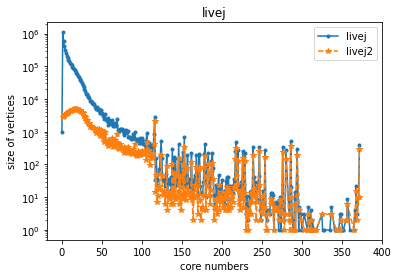

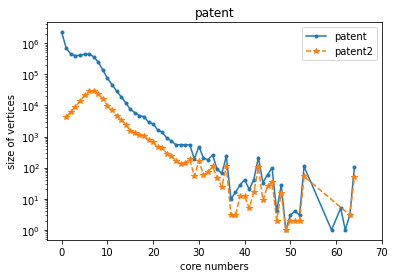

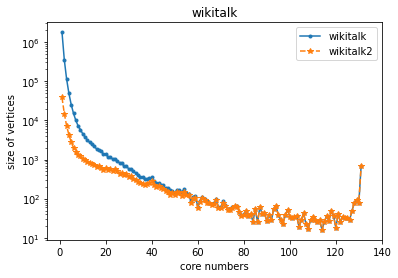

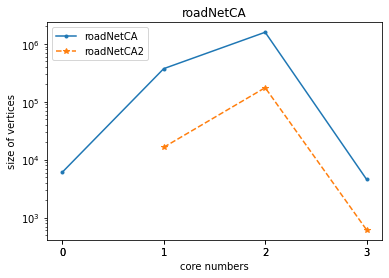

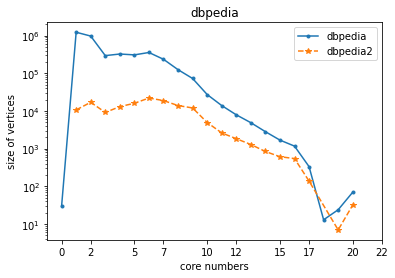

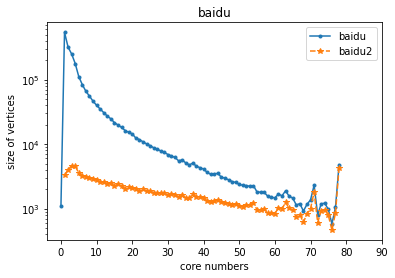

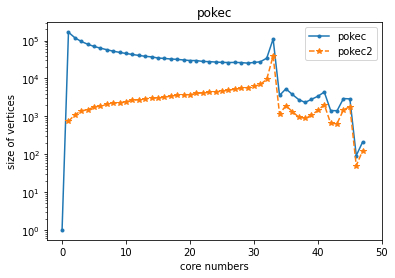

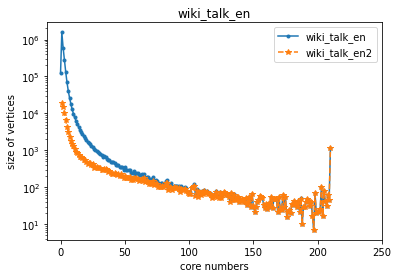

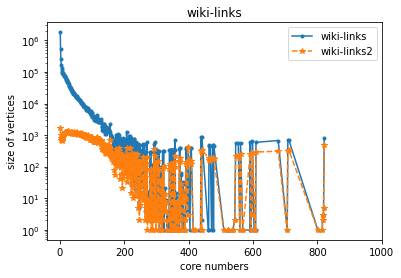

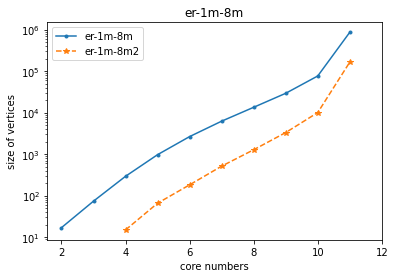

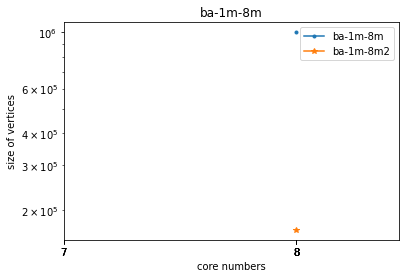

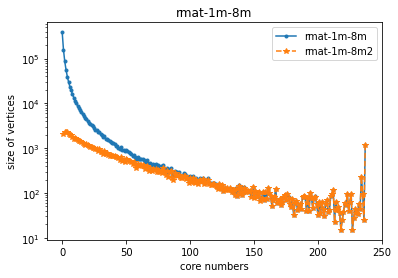

In [19]:
def draw_graph_core():
    global graph_name
    index = 1
    time = 0
    for name in graph_name:
        #plt.subplot(240+index)
        x, y = read_graph_core_data(name)
        x2, y2 = read_graph_core_data2(name)
        #avg = calculate_avg_order_size(x, y)
        #plt.bar(x, y, label=name, log=True)
        if (name == "ba-1m-8m"):
            plt.plot(x, y, label=name, marker="."); plt.yscale("log")
            plt.plot(x2, y2, label=name+"2", marker="*"); plt.yscale("log")
        else: 
            plt.plot(x, y, label=name, marker="."); plt.yscale("log")
            plt.plot(x2, y2, label=name+"2", linestyle='--', marker="*"); plt.yscale("log")
        plt.xlabel("core numbers")
        plt.ylabel("size of vertices")
        plt.legend()
        plt.title(name)
        
        
        # make the x ticks integers, not floats
        xint = []
        locs, labels = plt.xticks()
        for each in locs:
            xint.append(int(each))
        xint = xint[1:]
        plt.xticks(xint)
        
        plt.show(); 

      
        #plt.savefig(""name+".pdf")
draw_graph_core() # plot all in one figure. 

### all

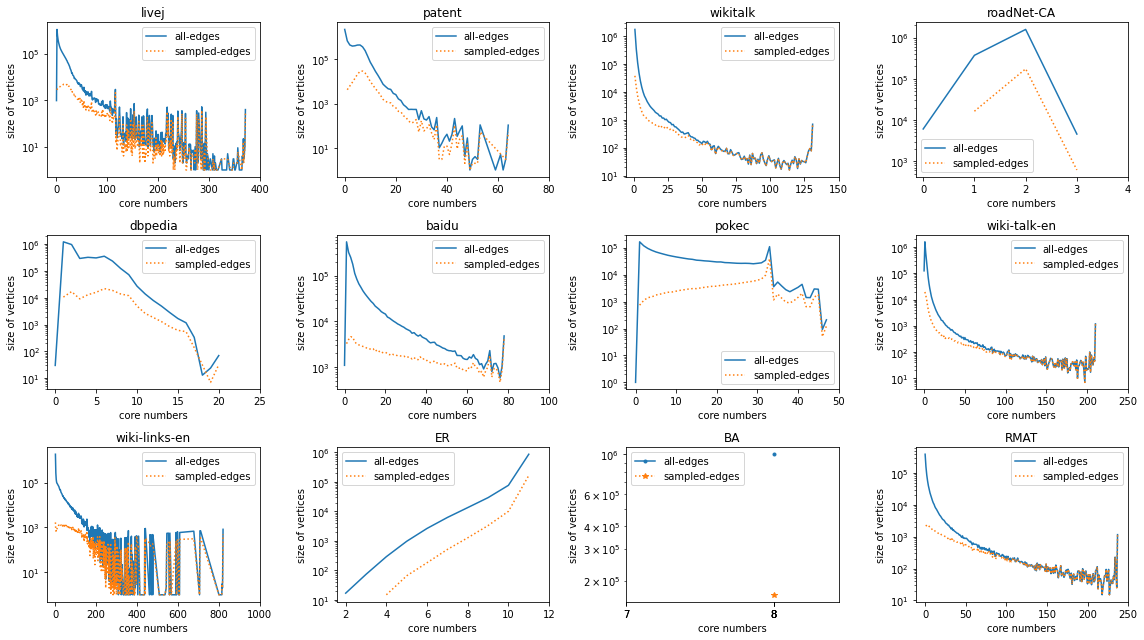

In [21]:
def draw_graph_core_figure():
    global graph_name; global graph_title
    index = 1
    time = 0
    fig = plt.figure(figsize=(16, 9))
    for name,title in zip(graph_name, graph_title):
        ax = fig.add_subplot(3, 4, index); index += 1
        ax.set_xlabel("core numbers")
        ax.set_ylabel("size of vertices")
        label1 = "all-edges"
        label2 = "sampled-edges"
        
        x, y = read_graph_core_data(name)
        x2, y2 = read_graph_core_data2(name)
        #avg = calculate_avg_order_size(x, y)
        #plt.bar(x, y, label=name, log=True)
        if (name == "ba-1m-8m"):
            ax.plot(x, y, label=label1, marker="."); plt.yscale("log")
            ax.plot(x2, y2, label=label2, marker="*", linestyle='dotted'); plt.yscale("log")
        else: 
            ax.plot(x, y, label=label1); plt.yscale("log")
            ax.plot(x2, y2, label=label2, linestyle='dotted'); plt.yscale("log")
        ax.legend()
        ax.set_title(title)
        
        
        #make the x ticks integers, not floats
        xint = []
        locs, labels = plt.xticks()
        for each in locs:
            xint.append(int(each))
        xint = xint[1:]
        ax.set_xticks(xint)
        
        time +=1
        if time >= 12: break
    fig.align_labels()
    fig.tight_layout()
    global ispdf
    plt.savefig("graph.pdf", bbox_inches='tight')
    plt.show();
draw_graph_core_figure() # plot all in one figure. 